In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeNormal, GlorotNormal
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD

In [2]:
# 무비렌즈 데이터 세트 호출
data_path = './ml-latest-small/'
df = pd.read_csv(data_path+'ratings.csv')

In [3]:
# binary implicit feedback
# rating >= 3.0일 경우 positive로 간주
df['rating'] = df['rating'].apply(lambda x: 1 if x >= 3.0 else 0)

# 전체 유저 수와 영화 수
n_users = df.userId.nunique()
n_movies = df.movieId.nunique()

# 데이터를 train/valid로 나눔
train, validation = train_test_split(df, test_size=0.2, random_state=42)

# 유저 아이디 indexing
unique_user_ids = df["userId"].unique()
userId_dict = {id: i for i, id in enumerate(unique_user_ids)}


# 영화 아이디 indexing
unique_movie_ids = df["movieId"].unique()
movieId_dict = {id: i for i, id in enumerate(unique_movie_ids)}

# 인덱싱 된 딕셔너리를 사용하여 ID 맵핑
train["userId"] = train["userId"].map(userId_dict)
train["movieId"] = train["movieId"].map(movieId_dict)

validation["userId"] = validation["userId"].map(userId_dict)
validation["movieId"] = validation["movieId"].map(movieId_dict)

# 전체 유니크 유저 수
num_unique_users = df['userId'].nunique() + 1
# 전체 유니크 영화 수
num_unique_movies = df['movieId'].nunique() + 1

In [7]:
with tf.device('/CPU:0'):
    # 유저/아이템 입력 레이어
    user_input = Input(shape=(1,))
    movie_input = Input(shape=(1,))

    # 임베딩 차원
    n_latent_factors = 20

    # 임베딩 레이어 정의
    user_embedding = Embedding(num_unique_users, n_latent_factors, name='user_embedding')(user_input)
    movie_embedding = Embedding(num_unique_movies, n_latent_factors, name='movie_embedding')(movie_input)

    # 임베딩 flatten
    user_vector = Flatten()(user_embedding)
    movie_vector = Flatten()(movie_embedding)

    # 유저 및 영화 임베딩 벡터 컨캣
    concat = Concatenate()([user_vector, movie_vector])

In [8]:
# MLP 생성하는 함수 -> 원하는 형태로 블록처럼 쌓을 수 있음
def create_mlp(hidden_layers, output):
    for i in range(len(hidden_layers)):
        if i == 0:
            hidden = Dense(hidden_layers[i], activation='relu')(output)
        else:
            hidden = Dense(hidden_layers[i], activation='relu')(hidden)
    output = Dense(1, activation='sigmoid')(hidden)  # 이진 출력은 시그모이드 활성화로
    return output

# create_mlp 함수를 사용하여 MLP 모델 생성
output = create_mlp([64, 64], concat)

In [9]:
# 최종 모델
model = Model(inputs=[user_input, movie_input], outputs=output)

In [10]:
# 모델을 컴파일 -> auc 함수로 평가
auc = tf.keras.metrics.AUC()

In [11]:
# 모델 요약
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 20)        12220       ['input_3[0][0]']                
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 20)        194500      ['input_4[0][0]']                
                                                                                            

In [12]:

# 로스 정보 업데이트 할 테이블
df = pd.DataFrame(columns=['Optimizer', 'Loss'])

# 모델 컴파일 -> 다른 옵티마이저 고려할 수 있도록


custom_optimizer_momentum = SGD(learning_rate=0.01, momentum=0.9)
custom_optimizer_nag = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

optimizers = ['adagrad','sgd', custom_optimizer_momentum, custom_optimizer_nag,
              'rmsprop', 'adadelta', 'adam', 'nadam']


# 로스 기록용 딕셔너리
loss_history = {}
with tf.device('/CPU:0'):
    for optimizer in optimizers:

        # 유저/아이템 입력 레이어
        user_input = Input(shape=(1,))
        movie_input = Input(shape=(1,))

        # 임베딩 차원
        n_latent_factors = 20

        # 임베딩 레이어 정의
        user_embedding = Embedding(num_unique_users, n_latent_factors, name='user_embedding')(user_input)
        movie_embedding = Embedding(num_unique_movies, n_latent_factors, name='movie_embedding')(movie_input)

        # 임베딩 flatten
        user_vector = Flatten()(user_embedding)
        movie_vector = Flatten()(movie_embedding)

        # 유저 및 영화 임베딩 벡터 컨캣
        concat = Concatenate()([user_vector, movie_vector])

        output = create_mlp([64, 64], concat)

        # 최종 모델
        model = Model(inputs=[user_input, movie_input], outputs=output)

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', auc])

        # 모델 적합
        history = model.fit([train.userId, train.movieId], train.rating, epochs=5,
                            verbose=2, validation_data=([validation.userId, validation.movieId], validation.rating))

        # 마지막 로스와 정확도 기록
        print(f"Optimizer: {optimizer}")
        print(f"Loss: {history.history['val_loss'][-1]}")
        print(f"Accuracy: {history.history['accuracy'][-1]}")

        df = pd.concat([df, 
        pd.DataFrame.from_records([{'Optimizer': optimizer, 'Loss': history.history['val_loss'][-1]}])
        ])
        # 딕셔너리 업데이트
        loss_history[str(optimizer)] = history.history['val_loss']


Epoch 1/5


2025-04-09 21:20:22.179206: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-04-09 21:20:22.547702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-04-09 21:20:26.679779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2521/2521 - 5s - loss: 0.5686 - accuracy: 0.8101 - auc: 0.4966 - val_loss: 0.5067 - val_accuracy: 0.8091 - val_auc: 0.5226 - 5s/epoch - 2ms/step
Epoch 2/5
2521/2521 - 5s - loss: 0.4902 - accuracy: 0.8113 - auc: 0.5110 - val_loss: 0.4871 - val_accuracy: 0.8091 - val_auc: 0.5483 - 5s/epoch - 2ms/step
Epoch 3/5
2521/2521 - 5s - loss: 0.4831 - accuracy: 0.8113 - auc: 0.5532 - val_loss: 0.4854 - val_accuracy: 0.8091 - val_auc: 0.5724 - 5s/epoch - 2ms/step
Epoch 4/5
2521/2521 - 5s - loss: 0.4818 - accuracy: 0.8113 - auc: 0.5826 - val_loss: 0.4842 - val_accuracy: 0.8091 - val_auc: 0.5962 - 5s/epoch - 2ms/step
Epoch 5/5
2521/2521 - 5s - loss: 0.4804 - accuracy: 0.8113 - auc: 0.6085 - val_loss: 0.4827 - val_accuracy: 0.8091 - val_auc: 0.6176 - 5s/epoch - 2ms/step
Optimizer: adagrad
Loss: 0.4826936721801758
Accuracy: 0.8112882375717163
Epoch 1/5


/var/folders/1l/w3vzbf215cs4ll30rh71l7wr6ghggx/T/ipykernel_2485/993442647.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,
2025-04-09 21:20:47.153184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-04-09 21:20:51.768434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2521/2521 - 6s - loss: 0.4937 - accuracy: 0.8107 - auc: 0.5428 - val_loss: 0.4854 - val_accuracy: 0.8091 - val_auc: 0.5791 - 6s/epoch - 2ms/step
Epoch 2/5
2521/2521 - 6s - loss: 0.4795 - accuracy: 0.8113 - auc: 0.6072 - val_loss: 0.4787 - val_accuracy: 0.8091 - val_auc: 0.6391 - 6s/epoch - 2ms/step
Epoch 3/5
2521/2521 - 5s - loss: 0.4684 - accuracy: 0.8113 - auc: 0.6657 - val_loss: 0.4629 - val_accuracy: 0.8091 - val_auc: 0.6886 - 5s/epoch - 2ms/step
Epoch 4/5
2521/2521 - 5s - loss: 0.4496 - accuracy: 0.8111 - auc: 0.7056 - val_loss: 0.4442 - val_accuracy: 0.8132 - val_auc: 0.7156 - 5s/epoch - 2ms/step
Epoch 5/5
2521/2521 - 5s - loss: 0.4343 - accuracy: 0.8159 - auc: 0.7290 - val_loss: 0.4341 - val_accuracy: 0.8146 - val_auc: 0.7306 - 5s/epoch - 2ms/step
Optimizer: sgd
Loss: 0.43414169549942017
Accuracy: 0.8158501386642456
Epoch 1/5


2025-04-09 21:21:13.873700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-04-09 21:21:18.676367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2521/2521 - 6s - loss: 0.4590 - accuracy: 0.8123 - auc: 0.6711 - val_loss: 0.4315 - val_accuracy: 0.8157 - val_auc: 0.7352 - 6s/epoch - 2ms/step
Epoch 2/5
2521/2521 - 7s - loss: 0.4171 - accuracy: 0.8203 - auc: 0.7557 - val_loss: 0.4114 - val_accuracy: 0.8224 - val_auc: 0.7699 - 7s/epoch - 3ms/step
Epoch 3/5
2521/2521 - 5s - loss: 0.3910 - accuracy: 0.8294 - auc: 0.7976 - val_loss: 0.4031 - val_accuracy: 0.8261 - val_auc: 0.7879 - 5s/epoch - 2ms/step
Epoch 4/5
2521/2521 - 5s - loss: 0.3734 - accuracy: 0.8368 - auc: 0.8210 - val_loss: 0.4032 - val_accuracy: 0.8233 - val_auc: 0.7893 - 5s/epoch - 2ms/step
Epoch 5/5
2521/2521 - 5s - loss: 0.3605 - accuracy: 0.8438 - auc: 0.8359 - val_loss: 0.4021 - val_accuracy: 0.8273 - val_auc: 0.7962 - 5s/epoch - 2ms/step
Optimizer: <keras.optimizers.optimizer_v2.gradient_descent.SGD object at 0x105d8fa60>
Loss: 0.40212729573249817
Accuracy: 0.8438290357589722
Epoch 1/5


2025-04-09 21:21:41.782529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-04-09 21:21:45.773292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2521/2521 - 5s - loss: 0.4511 - accuracy: 0.8156 - auc: 0.7015 - val_loss: 0.4297 - val_accuracy: 0.8144 - val_auc: 0.7414 - 5s/epoch - 2ms/step
Epoch 2/5
2521/2521 - 5s - loss: 0.4108 - accuracy: 0.8215 - auc: 0.7669 - val_loss: 0.4096 - val_accuracy: 0.8220 - val_auc: 0.7733 - 5s/epoch - 2ms/step
Epoch 3/5
2521/2521 - 5s - loss: 0.3859 - accuracy: 0.8299 - auc: 0.8055 - val_loss: 0.4030 - val_accuracy: 0.8280 - val_auc: 0.7876 - 5s/epoch - 2ms/step
Epoch 4/5
2521/2521 - 5s - loss: 0.3692 - accuracy: 0.8395 - auc: 0.8264 - val_loss: 0.3988 - val_accuracy: 0.8239 - val_auc: 0.7932 - 5s/epoch - 2ms/step
Epoch 5/5
2521/2521 - 5s - loss: 0.3564 - accuracy: 0.8455 - auc: 0.8406 - val_loss: 0.3953 - val_accuracy: 0.8289 - val_auc: 0.7960 - 5s/epoch - 2ms/step
Optimizer: <keras.optimizers.optimizer_v2.gradient_descent.SGD object at 0x305396800>
Loss: 0.39527571201324463
Accuracy: 0.8455273509025574
Epoch 1/5


2025-04-09 21:22:05.963530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-04-09 21:22:10.141375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2521/2521 - 6s - loss: 0.4236 - accuracy: 0.8246 - auc: 0.7516 - val_loss: 0.4125 - val_accuracy: 0.8291 - val_auc: 0.7640 - 6s/epoch - 2ms/step
Epoch 2/5
2521/2521 - 6s - loss: 0.3904 - accuracy: 0.8395 - auc: 0.7893 - val_loss: 0.4141 - val_accuracy: 0.8286 - val_auc: 0.7699 - 6s/epoch - 2ms/step
Epoch 3/5
2521/2521 - 6s - loss: 0.3800 - accuracy: 0.8453 - auc: 0.8007 - val_loss: 0.4078 - val_accuracy: 0.8289 - val_auc: 0.7749 - 6s/epoch - 2ms/step
Epoch 4/5
2521/2521 - 5s - loss: 0.3726 - accuracy: 0.8500 - auc: 0.8077 - val_loss: 0.4109 - val_accuracy: 0.8296 - val_auc: 0.7736 - 5s/epoch - 2ms/step
Epoch 5/5
2521/2521 - 6s - loss: 0.3661 - accuracy: 0.8542 - auc: 0.8137 - val_loss: 0.4213 - val_accuracy: 0.8242 - val_auc: 0.7779 - 6s/epoch - 2ms/step
Optimizer: rmsprop
Loss: 0.42128679156303406
Accuracy: 0.8541676998138428
Epoch 1/5


2025-04-09 21:22:34.871722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-04-09 21:22:38.984539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2521/2521 - 5s - loss: 0.6871 - accuracy: 0.6969 - auc: 0.5595 - val_loss: 0.6788 - val_accuracy: 0.8082 - val_auc: 0.4999 - 5s/epoch - 2ms/step
Epoch 2/5
2521/2521 - 5s - loss: 0.6692 - accuracy: 0.8112 - auc: 0.4959 - val_loss: 0.6597 - val_accuracy: 0.8091 - val_auc: 0.4988 - 5s/epoch - 2ms/step
Epoch 3/5
2521/2521 - 6s - loss: 0.6492 - accuracy: 0.8113 - auc: 0.4990 - val_loss: 0.6392 - val_accuracy: 0.8091 - val_auc: 0.4980 - 6s/epoch - 2ms/step
Epoch 4/5
2521/2521 - 6s - loss: 0.6283 - accuracy: 0.8113 - auc: 0.4988 - val_loss: 0.6183 - val_accuracy: 0.8091 - val_auc: 0.5025 - 6s/epoch - 2ms/step
Epoch 5/5
2521/2521 - 5s - loss: 0.6073 - accuracy: 0.8113 - auc: 0.5036 - val_loss: 0.5976 - val_accuracy: 0.8091 - val_auc: 0.5092 - 5s/epoch - 2ms/step
Optimizer: adadelta
Loss: 0.5975983142852783
Accuracy: 0.8112882375717163
Epoch 1/5


2025-04-09 21:23:02.481177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-04-09 21:23:08.430107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2521/2521 - 7s - loss: 0.4081 - accuracy: 0.8261 - auc: 0.7147 - val_loss: 0.3912 - val_accuracy: 0.8309 - val_auc: 0.7995 - 7s/epoch - 3ms/step
Epoch 2/5
2521/2521 - 6s - loss: 0.3499 - accuracy: 0.8502 - auc: 0.8446 - val_loss: 0.3932 - val_accuracy: 0.8318 - val_auc: 0.8022 - 6s/epoch - 2ms/step
Epoch 3/5
2521/2521 - 6s - loss: 0.3195 - accuracy: 0.8641 - auc: 0.8730 - val_loss: 0.4101 - val_accuracy: 0.8228 - val_auc: 0.7972 - 6s/epoch - 2ms/step
Epoch 4/5
2521/2521 - 6s - loss: 0.2953 - accuracy: 0.8750 - auc: 0.8930 - val_loss: 0.4175 - val_accuracy: 0.8230 - val_auc: 0.7895 - 6s/epoch - 3ms/step
Epoch 5/5
2521/2521 - 7s - loss: 0.2741 - accuracy: 0.8841 - auc: 0.9088 - val_loss: 0.4379 - val_accuracy: 0.8179 - val_auc: 0.7776 - 7s/epoch - 3ms/step
Optimizer: adam
Loss: 0.4379151165485382
Accuracy: 0.8841052055358887
Epoch 1/5


2025-04-09 21:23:35.482311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-04-09 21:23:40.647573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2521/2521 - 7s - loss: 0.4098 - accuracy: 0.8256 - auc: 0.7669 - val_loss: 0.3929 - val_accuracy: 0.8289 - val_auc: 0.7980 - 7s/epoch - 3ms/step
Epoch 2/5
2521/2521 - 6s - loss: 0.3504 - accuracy: 0.8504 - auc: 0.8445 - val_loss: 0.3938 - val_accuracy: 0.8315 - val_auc: 0.8021 - 6s/epoch - 2ms/step
Epoch 3/5
2521/2521 - 6s - loss: 0.3218 - accuracy: 0.8642 - auc: 0.8709 - val_loss: 0.4058 - val_accuracy: 0.8272 - val_auc: 0.7959 - 6s/epoch - 2ms/step
Epoch 4/5
2521/2521 - 6s - loss: 0.3012 - accuracy: 0.8733 - auc: 0.8881 - val_loss: 0.4216 - val_accuracy: 0.8279 - val_auc: 0.7914 - 6s/epoch - 2ms/step
Epoch 5/5
2521/2521 - 6s - loss: 0.2840 - accuracy: 0.8810 - auc: 0.9015 - val_loss: 0.4428 - val_accuracy: 0.8209 - val_auc: 0.7842 - 6s/epoch - 2ms/step
Optimizer: nadam
Loss: 0.4428406357765198
Accuracy: 0.8810185194015503


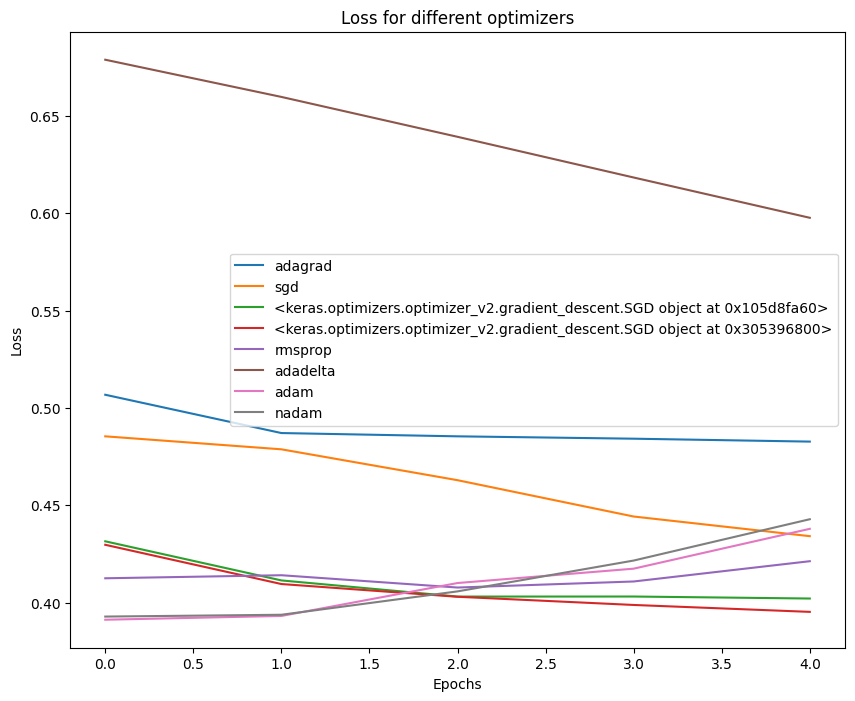

In [13]:
# 로스 시각화
plt.figure(figsize=(10, 8))

for optimizer, losses in loss_history.items():
    plt.plot(losses, label=optimizer)

plt.title("Loss for different optimizers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


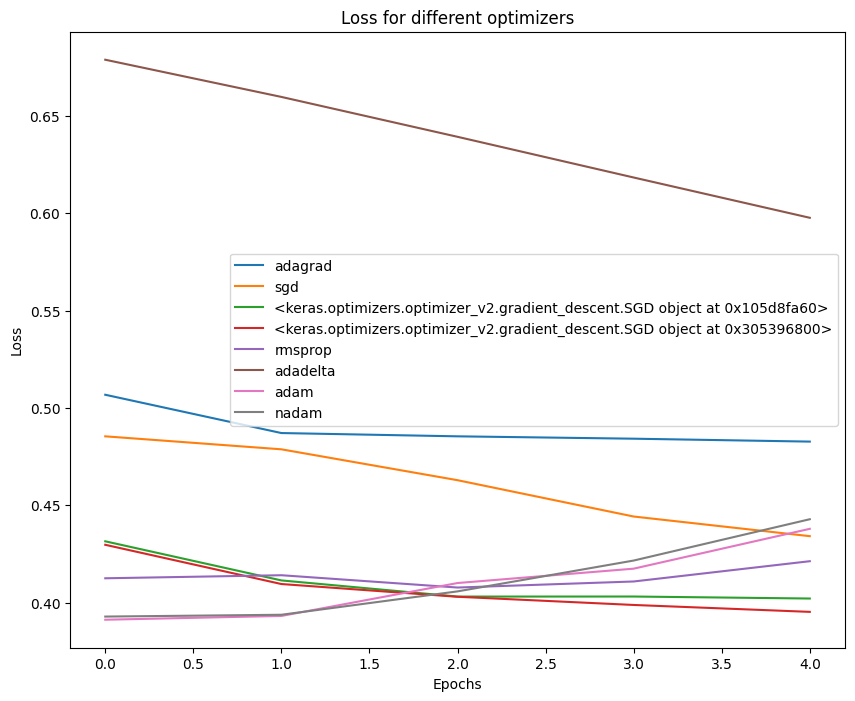

In [14]:

# 로스 시각화
plt.figure(figsize=(10, 8))

for optimizer, losses in loss_history.items():
    plt.plot(losses, label=optimizer)

plt.title("Loss for different optimizers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [15]:
display(df)

,Optimizer,Loss
0,adagrad,0.482694
0,sgd,0.434142
0,<keras.optimizers.optimizer_v2.gradient_descen...,0.402127
0,<keras.optimizers.optimizer_v2.gradient_descen...,0.395276
0,rmsprop,0.421287
0,adadelta,0.597598
0,adam,0.437915
0,nadam,0.442841


In [ ]:
# adam , Nadam 이 가장 초기 성능이 좋으나 epoch 이 증가할 수록 overfitting 이 발생